# <a id="top"></a>Intersecting grids with shapes

_Note: This feature requires the shapely and descartes packages (which are not a FloPy dependency) so must be installed by the user._

This notebook shows the grid intersection functionality in flopy. The intersection methods are available through the GridIntersect object. A flopy model grid is passed to instantiate the object. Then the modelgrid can be intersected with Points, LineStrings and Polygons through the different intersect methods. There are two intersection modes: 

This notebook showcases interpolation of z-data onto a grid.

## Contents

- Extend GridIntersect with interpolation functions
- Point observations and shapes:
  - [Case 1: Interpolate simple linestring with points at which z is defined](#case1)
  - [Case 2: Interpolate simple polygon with points at which z is defined (using a centerline)](#case2)
- Data from shapefiles (with attributes per shape):
  - [Case 3: Interpolate linestring with segments with z-data](#case3)
  - [Case 4: Interpolate from polygon with z-data](#case4)

Import some stuff

In [1]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.insert(1, "../..")

# run installed version of flopy or add local path
try:
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.triangle import Triangle as Triangle
    from flopy.utils.gridintersect import GridIntersect
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.triangle import Triangle as Triangle
    from flopy.utils.gridintersect import GridIntersect

import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
from shapely.strtree import STRtree    

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
numpy version: 1.19.2
matplotlib version: 3.3.2
flopy version: 3.3.2


## Interpolation functions

In [2]:
class GridIntersect_z(GridIntersect):

    def calc_interpweights_linestring(self, ixresult, linestring, xyz):
        """Calculate interpolation weights for cell centers of gridcells that
        intersect with a linestring given a set of points with z-values.

        Parameters
        ----------
        linestring : shapely.geometry.Linestring
            shapely representation of linestring
        xyz : numpy.array
            numpy array containing (x, y, z) data per row for points with
            z-values. These do not necessarily have to lie exactly on the
            linestring (they are also projected onto the linestring).

        Returns
        -------
        weights : np.array
            array with dimensions (n_gridcells, n_pts) where n_pts is the
            number of points at which z-data is defined. Each row contains
            1 or 2 non-zero values (with sum equal to 1). These values
            represent the interpolation weights

        """

        # project pts with z-data onto linestring
        zpts = [Point(*ixyz) for ixyz in xyz]
        dist_along_ls_z = [linestring.project(z) for z in zpts]

        # project cell coords (x, y) onto linestring
        if self.mfgrid.grid_type == "structured":
            xypts = [Point(self.mfgrid.xcellcenters[0, icol],
                           self.mfgrid.ycellcenters[irow, 0])
                     for irow, icol in ixresult.cellids]
        elif self.mfgrid.grid_type == "vertex":
            xypts = [Point(self.mfgrid.xcellcenters[i],
                           self.mfgrid.ycellcenters[i])
                     for i in ixresult.cellids]
        else:
            raise NotImplementedError("Only works for 'structured' or "
                                      "'vertex' grids!")
        
        # projected distance of cell centers along linestring
        dist_along_ls_cells = [linestring.project(p) for p in xypts]

        # calculate linear weights between z-pts
        linear_weights = np.interp(
            dist_along_ls_cells, dist_along_ls_z, range(len(dist_along_ls_z)))

        # fill weights matrix
        weights = np.zeros((len(xypts), len(zpts)))
        for irow in range(len(xypts)):
            w = linear_weights[irow]
            w1 = 1 - (w - int(w)) if w > 0 else 1
            w2 = 1 - w1 if w < len(zpts) else 1
            weights[irow, int(w)] = w1
            
            if int(w) + 1 < len(zpts):
                weights[irow, int(w) + 1] = w2

        return weights

    def interpolate_z_along_linestring(self, linestring, xyz):
        """Calculate z-value for cell centers of gridcells that intersect
        with a linestring given a set of points with defined z-values.

        Parameters
        ----------
        linestring : shapely.geometry.Linestring
            shapely representation of a linestring
        xyz : numpy.array
            numpy array containing (x, y, z) data per row for points with
            z-values. These do not necessarily have to lie exactly on the
            linestring (they are also projected onto the linestring).

        Returns
        -------
        result : numpy.recarray
            numpy record arrray with intersection result and interpolated
            nearest z-values

        """
        ixresult = self.intersect_linestring(linestring)
        weights = self.calc_interpweights_linestring(ixresult, linestring, xyz)
        return weights.dot(xyz[:, -1:])
    
    def interpolate_z_along_polygon(self, polygon, centerline, xyz):
        """Calculate z-value for cell centers of gridcells that intersect
        with a polygon given a set of points with defined z-values.

        Parameters
        ----------
        polygon : shapely.geometry.Polygon
            shapely representation of a polygon
        centerline : shapely.geometry.LineString
            centerline of the polygon
        xyz : numpy.array
            numpy array containing (x, y, z) data per row for points with
            z-values. These do not necessarily have to lie exactly on the
            linestring (they are also projected onto the linestring).

        Returns
        -------
        result : numpy.recarray
            numpy record arrray with intersection result and interpolated
            nearest z-values

        """
        ixresult = self.intersect_polygon(polygon)
        weights = self.calc_interpweights_linestring(ixresult, centerline, xyz)
        return weights.dot(xyz[:, -1:])

Rectangular regular grid

In [218]:
delc = 10*np.ones(10, dtype=np.float)
delr = 10*np.ones(10, dtype=np.float)

In [219]:
xoff = 0.
yoff = 0.
angrot = 0.
sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot)

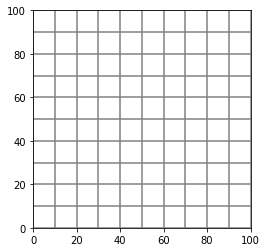

In [220]:
sgr.plot()

Create GridIntersect class

In [17]:
ix = GridIntersect_z(sgr, method="vertex")

## <a id="case1"></a>[Case 1: Interpolate simple linestring with points at which z is defined](#top)
MultiLineString to intersect with:

In [8]:
ls1 = LineString([(95, 105), (30, 50)])
ls2 = LineString([(30, 50), (90, 22)])
ls3 = LineString([(90, 22), (0, 0)])
mls = MultiLineString(lines=[ls1, ls2, ls3])

Points containing z-data. These points lie on the line, but this is not necessarily required as the data points are also projected onto the line.

In [9]:
xyz = np.array([[95, 105, 10], [30, 50, 20], [0, 0, 0]])

Calculate elevation for gridcell centers by projecting cell-center coordinates onto linestring and linearly interpolating between known z-values.

In [9]:
elev = ix.interpolate_z_along_linestring(mls, xyz)
result = ix.intersect_linestring(mls)

Plot result

../..\flopy\utils\gridintersect.py:1090: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  c="C{}".format(i % 10), **kwargs)
../..\flopy\utils\gridintersect.py:1087: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  c="C{}".format(i % 10), **kwargs)


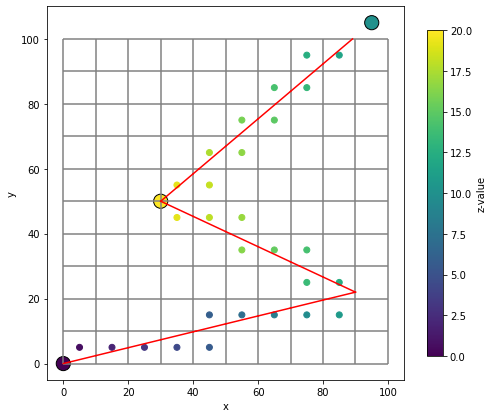

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_linestring(result, ax=ax, color="red")

xy_arr = np.array([[sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0]] for irow, icol in result.cellids])
sc = ax.scatter(xy_arr[:, 0], xy_arr[:, 1], c=elev.squeeze(), cmap="viridis", vmin=0, vmax=20)
sc2 = ax.scatter(xyz[:, 0], xyz[:, 1], c=xyz[:, -1], cmap="viridis", vmin=0, vmax=20, edgecolors="k", s=200)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 110)
cbar = fig.colorbar(sc, ax=ax, shrink=0.75);
cbar.set_label("z-value")
ax.set_xlabel("x")
ax.set_ylabel("y");

## <a id="case2"></a>[Case 2: Interpolate simple polygon with points at which z is defined (using a centerline)](#top)

In [11]:
poly = Polygon(shell=[(100, 105), (70, 105), (30, 50.), (60, 0), (90, 0), (60, 50), (80, 80), (100, 80)])
centerline = LineString([(100, 92.5), (75, 92.5), (45, 50) ,(75, 0)])

In [12]:
result = ix.intersect_polygon(poly)

In [13]:
xyz = np.array([[100, 92.5, 10], [50, 50, 20], [75, 0, 0]])

In [14]:
elev = ix.interpolate_z_along_polygon(poly, centerline, xyz)

C:\Users\dbrak\Anaconda3\lib\site-packages\descartes\patch.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return PathPatch(PolygonPath(polygon), **kwargs)


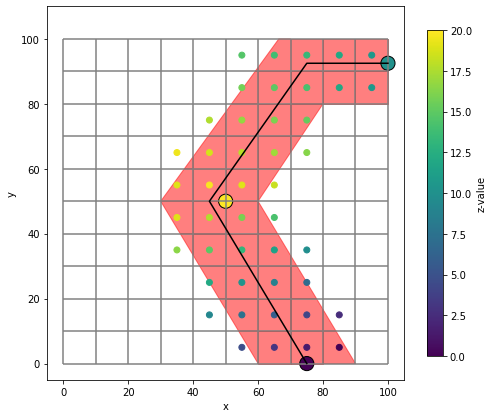

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_polygon(result, ax=ax, color="red", zorder=0, alpha=0.5)
ax.plot(centerline.xy[0], centerline.xy[1], ls="-", c="k")

xy_arr = np.array([[sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0]] for irow, icol in result.cellids])
sc = ax.scatter(xy_arr[:, 0], xy_arr[:, 1], c=elev.squeeze(), cmap="viridis", vmin=0, vmax=20)
sc2 = ax.scatter(xyz[:, 0], xyz[:, 1], c=xyz[:, -1], cmap="viridis", vmin=0, vmax=20, edgecolors="k", s=200)
ax.set_xlim(-5, 105)
ax.set_ylim(-5, 110)
cbar = fig.colorbar(sc, ax=ax, shrink=0.75);
cbar.set_label("z-value")
ax.set_xlabel("x")
ax.set_ylabel("y");

## <a id="case3"></a>[Case 3: Interpolate linestring with segments with z-data](#top)

In [16]:
import geopandas as gpd

In [17]:
pt = MultiPoint([mls.interpolate(i/4, normalized=True) for i in range(1, 4)])

# snap line to points to avoid floating point issues when splitting
mls = shapely.ops.snap(mls, pt, tolerance=1e-5)
ls_split = shapely.ops.split(mls, pt)

In [18]:
gdf = gpd.GeoDataFrame(geometry=list(ls_split))
gdf["z"] = np.arange(gdf.shape[0]) + 5
gdf

,geometry,z
0,"LINESTRING (95.000 105.000, 48.432 65.596)",5
1,"LINESTRING (48.432 65.596, 30.000 50.000)",6
2,"LINESTRING (30.000 50.000, 63.400 34.414)",7
3,"LINESTRING (63.400 34.414, 90.000 22.000)",8
4,"LINESTRING (90.000 22.000, 59.257 14.485)",9
5,"LINESTRING (59.257 14.485, 0.000 0.000)",10


In [19]:
import pandas as pd

In [20]:
# intersect with modelgrid and store attributes
keep_cols = ["z"]
collect_ix = []

for irow, ishp in gdf.iterrows():
    r = ix.intersect_linestring(ishp.geometry)
    idf = gpd.GeoDataFrame(r, geometry="ixshapes")
    # add attributes
    for icol in keep_cols:
        idf[icol] = ishp[icol]
    collect_ix.append(idf)

ix_df = pd.concat(collect_ix, axis=0)
ix_df.reset_index(inplace=True, drop=True)

In [21]:
ix_df.sort_values(by="cellids").head(10)

,cellids,vertices,lengths,ixshapes,z
0,"(0, 7)","((80.0, 92.3076923076923), (77.27272727272728,...",3.572599,"LINESTRING (80.000 92.308, 77.273 90.000)",5
1,"(0, 8)","((89.0909090909091, 100.0), (80.0, 92.30769230...",11.908662,"LINESTRING (89.091 100.000, 80.000 92.308)",5
2,"(1, 6)","((70.0, 83.84615384615384), (65.45454545454545...",5.954331,"LINESTRING (70.000 83.846, 65.455 80.000)",5
3,"(1, 7)","((77.27272727272728, 90.0), (70.0, 83.84615384...",9.526929,"LINESTRING (77.273 90.000, 70.000 83.846)",5
4,"(2, 5)","((60.0, 75.38461538461539), (53.63636363636364...",8.336063,"LINESTRING (60.000 75.385, 53.636 70.000)",5
5,"(2, 6)","((65.45454545454545, 80.0), (60.0, 75.38461538...",7.145197,"LINESTRING (65.455 80.000, 60.000 75.385)",5
6,"(3, 4)","((50.0, 66.92307692307692), (48.43179687045732...",2.054272,"LINESTRING (50.000 66.923, 48.432 65.596)",5
8,"(3, 4)","((48.431796870457326, 65.59613581346389), (41....",8.663524,"LINESTRING (48.432 65.596, 41.818 60.000)",6
7,"(3, 5)","((53.63636363636364, 70.0), (50.0, 66.92307692...",4.763465,"LINESTRING (53.636 70.000, 50.000 66.923)",5
9,"(4, 3)","((40.0, 58.46153846153846), (30.0, 50.0))",13.099528,"LINESTRING (40.000 58.462, 30.000 50.000)",6


In [22]:
# aggregation method with groupby
gr = ix_df.groupby(by="cellids")
calc_cols = ["z"]
mdata = pd.DataFrame(index=gr.groups.keys())
for igr, group in gr:
    for icol in calc_cols:
        # length-weighted
        mdata.loc[igr, icol] = (group.lengths * group[icol]).sum() / group.lengths.sum()

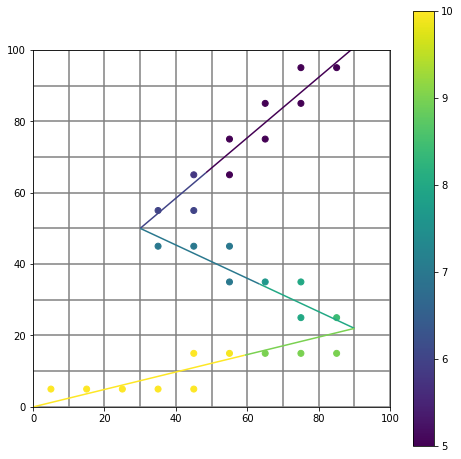

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

gdf.plot(ax=ax, column="z", legend=True)

xy_arr = np.array([[sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0]] for irow, icol in mdata.index])
sc = ax.scatter(xy_arr[:, 0], xy_arr[:, 1], c=mdata["z"], cmap="viridis", vmin=5, vmax=10)

## <a id="case4"></a>[Case 4: Interpolate from polygon with z-data](#top)

In [24]:
poly = Polygon(shell=[(100, 105), (70, 105), (30, 50.), (60, 0), (90, 0), (60, 50), (80, 80), (100, 80)])

In [25]:
splitter = [
    LineString([(90, 105), (90, 80)]),
    LineString([(40, 90), (80, 70)]),
    LineString([(30, 50), (70, 50)]),
    LineString([(40, 20), (80, 30)])
]

In [26]:
geoms = []
for i, split in enumerate(splitter):
    res = shapely.ops.split(poly, split)
    geoms.append(res[0])
    poly = res[1]
    if i == len(splitter)-1:
        geoms.append(res[1])

In [27]:
gdf = gpd.GeoDataFrame(geometry=geoms)
gdf["z"] = np.arange(gdf.shape[0]) + 5
gdf

,geometry,z
0,"POLYGON ((90.000 105.000, 100.000 105.000, 100...",5
1,"POLYGON ((90.000 80.000, 80.000 80.000, 75.000...",6
2,"POLYGON ((75.000 72.500, 60.000 50.000, 30.000...",7
3,"POLYGON ((60.000 50.000, 73.043 28.261, 46.957...",8
4,"POLYGON ((73.043 28.261, 90.000 0.000, 60.000 ...",9


In [28]:
# intersect with modelgrid and store attributes
keep_cols = ["z"]
collect_ix = []

for irow, ishp in gdf.iterrows():
    r = ix.intersect_polygon(ishp.geometry)
    idf = gpd.GeoDataFrame(r, geometry="ixshapes")
    # add attributes
    for icol in keep_cols:
        idf[icol] = ishp[icol]
    collect_ix.append(idf)

ix_df = pd.concat(collect_ix, axis=0)
ix_df.reset_index(inplace=True, drop=True)

In [29]:
ix_df.sort_values(by="cellids").head(10)

,cellids,vertices,areas,ixshapes,z
2,"(0, 5)","(((59.09090909090909, 90.0), (60.0, 91.25), (6...",0.568182,"POLYGON ((59.091 90.000, 60.000 91.250, 60.000...",6
3,"(0, 6)","(((60.0, 91.25), (66.36363636363636, 100.0), (...",72.159091,"POLYGON ((60.000 91.250, 66.364 100.000, 70.00...",6
4,"(0, 7)","(((70.0, 100.0), (80.0, 100.0), (80.0, 90.0), ...",100.000000,"POLYGON ((70.000 100.000, 80.000 100.000, 80.0...",6
5,"(0, 8)","(((90.0, 100.0), (90.0, 90.0), (80.0, 90.0), (...",100.000000,"POLYGON ((90.000 100.000, 90.000 90.000, 80.00...",6
0,"(0, 9)","(((100.0, 100.0), (100.0, 90.0), (90.0, 90.0),...",100.000000,"POLYGON ((100.000 100.000, 100.000 90.000, 90....",5
6,"(1, 5)","(((60.0, 80.0), (54.0, 83.0), (59.090909090909...",33.181818,"POLYGON ((60.000 80.000, 54.000 83.000, 59.091...",6
12,"(1, 5)","(((51.81818181818182, 80.0), (54.0, 83.0), (60...",12.272727,"POLYGON ((51.818 80.000, 54.000 83.000, 60.000...",7
7,"(1, 6)","(((60.0, 90.0), (70.0, 90.0), (70.0, 80.0), (6...",100.000000,"POLYGON ((60.000 90.000, 70.000 90.000, 70.000...",6
8,"(1, 7)","(((70.0, 90.0), (80.0, 90.0), (80.0, 80.0), (7...",100.000000,"POLYGON ((70.000 90.000, 80.000 90.000, 80.000...",6
9,"(1, 8)","(((90.0, 80.0), (80.0, 80.0), (80.0, 90.0), (9...",100.000000,"POLYGON ((90.000 80.000, 80.000 80.000, 80.000...",6


In [30]:
# aggregation method with groupby
gr = ix_df.groupby(by="cellids")
calc_cols = ["z"]
mdata = pd.DataFrame(index=gr.groups.keys())
for igr, group in gr:
    for icol in calc_cols:
        # area-weighted
        mdata.loc[igr, icol] = (group.areas * group[icol]).sum() / group.areas.sum()

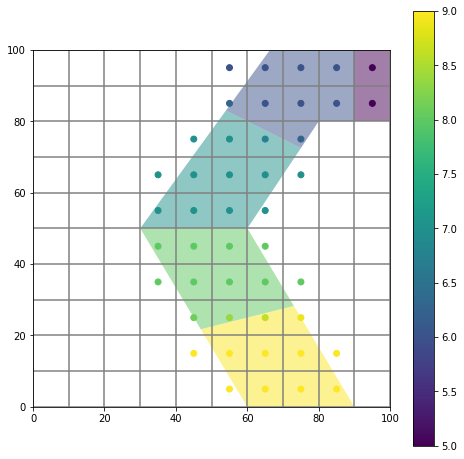

In [31]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

gdf.plot(ax=ax, column="z", legend=True, alpha=0.5)

xy_arr = np.array([[sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0]] for irow, icol in mdata.index])
sc = ax.scatter(xy_arr[:, 0], xy_arr[:, 1], c=mdata["z"], cmap="viridis", vmin=5, vmax=9)

## Sidenote: performance rtree, strtree

Performance of rtree, strtree, and filter with prepped polygon

This is the method implemented in flopy at the moment:

In [1]:
poly = Polygon(shell=[(100, 105), (70, 105), (30, 50.), (60, 0), (90, 0), (60, 50), (80, 80), (100, 80)])

NameError: name 'Polygon' is not defined

In [34]:
%timeit ix.strtree.query(poly)

88.8 µs ± 754 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


I found a reference to Rtree being a lot faster than shapely's STRtree on Stackoverflow: https://gis.stackexchange.com/questions/353619/shapely-with-rtree-versus-strtree

In [35]:
import rtree

In [36]:
# Create RTree
idx = rtree.index.Index()
for i, icell in enumerate(ix.gridshapes):
    idx.insert(i, icell.bounds, icell)

In [38]:
%timeit idx.intersection(poly.bounds, objects="raw")

64.5 µs ± 513 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In shapely docs I also found `shapely.prepared.prep` which somehow prepares a shape for batch operations:

In [41]:
prep_poly = shapely.prepared.prep(poly)

In [42]:
%timeit filter(prep_poly.intersects, ix.gridshapes)

184 ns ± 6 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Rtree is faster than STRtree, but the prepped polygon method is faster by a mile. The speed difference is huge... But maybe this advantage disappears quickly for larger modelgrids? I will test this more later.

In [43]:
np.timedelta64(92, "us") / np.timedelta64(188, "ns")

489.36170212765956

## Normalized interpolation distances along linestring

In [10]:
LineString?

Init signature: LineString(coordinates=None)
Docstring:     
A one-dimensional figure comprising one or more line segments

A LineString has non-zero length and zero area. It may approximate a curve
and need not be straight. Unlike a LinearRing, a LineString is not closed.
Init docstring:
Parameters
----------
coordinates : sequence
    A sequence of (x, y [,z]) numeric coordinate pairs or triples or
    an object that provides the numpy array interface, including
    another instance of LineString.

Example
-------
Create a line with two segments

  >>> a = LineString([[0, 0], [1, 0], [1, 1]])
  >>> a.length
  2.0
File:           ~/anaconda3/lib/python3.7/site-packages/shapely/geometry/linestring.py
Type:           type
Subclasses:     LineStringAdapter, LinearRing


In [19]:
rec = ix.intersect_linestring(mls)

In [23]:
ixls0 = rec.ixshapes[0]

In [46]:
ixls0.xy

(array('d', [80.0, 77.27272727272727]), array('d', [92.3076923076923, 90.0]))

In [33]:
xy = np.array(ixls0.xy)

In [50]:
mls.project(Point(*xy[:, 0]), normalized=True)

0.08052704953137897

In [18]:
ix.method

'vertex'

In [47]:
ls1.xy

(array('d', [95.0, 30.0]), array('d', [105.0, 50.0]))

In [48]:
xy1 = np.array(ls1.xy)
xy1

array([[ 95.,  30.],
       [105.,  50.]])

In [49]:
mls.project(Point(*xy1[:, 0]), normalized=True)

0.0

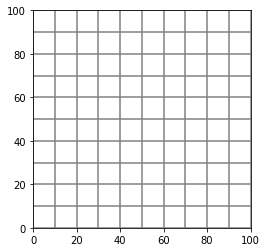

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ax.plot(xy[])

In [57]:
tls1 = LineString([(0, 0), (1, 0)])
tls2 = LineString([(0, 0), (1, -1)])

from shapely.ops import linemerge

In [58]:
ls = linemerge([tls1, tls2])

In [59]:
type(ls)

shapely.geometry.linestring.LineString

In [61]:
ls.xy

(array('d', [1.0, 0.0, 1.0]), array('d', [-1.0, 0.0, 0.0]))

In [55]:
linemerge?

Signature: linemerge(lines)
Docstring:
Merges all connected lines from a source

The source may be a MultiLineString, a sequence of LineString objects,
or a sequence of objects than can be adapted to LineStrings.  Returns a
LineString or MultiLineString when lines are not contiguous.
File:      ~/anaconda3/lib/python3.7/site-packages/shapely/ops.py
Type:      method


In [62]:
delc = 10*np.ones(1, dtype=np.float)
delr = 10*np.ones(1, dtype=np.float)

In [63]:
xoff = 0.
yoff = 0.
angrot = 0.
sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot)

In [156]:
ls1 = LineString([(-1, 5), (0, 5)])
ls2 = LineString([(-1, 5), (1, 5)])
ls3 = LineString([(-1, 10), (10, 5), (-1, 0)])
ls4 = LineString([(-1, 10), (11, 5), (-1, 0)])
ls5 = MultiLineString([LineString([(-1, 7), (11, 7)]), LineString([(-1, 3), (11, 3)])])
ls_list = [ls1, ls2, ls3, ls4, ls5]

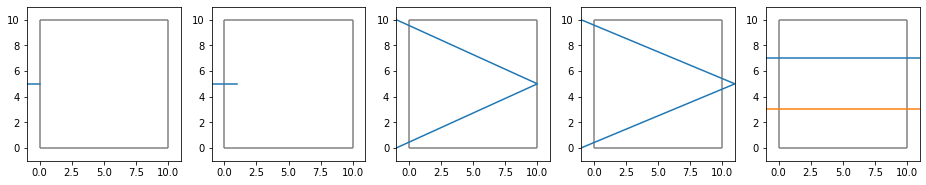

In [124]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, iax in enumerate(axes):
    sgr.plot(ax=iax)
    iax.set_xlim(-1, 11)
    iax.set_ylim(-1, 11)
    iax.set_aspect("equal", adjustable="box")
    
    if "Multi" in ls_list[i].geom_type:
        ls = ls_list[i]
    else:
        ls = [ls_list[i]]
    
    for part in ls:
        iax.plot(part.xy[0], part.xy[1], ls="-")

In [160]:
ix = GridIntersect(sgr, method="vertex")

In [126]:
ix.intersect_linestring(ls5)

rec.array([((0, 0), (((0.0, 7.0), (10.0, 7.0)), ((0.0, 3.0), (10.0, 3.0))), 20., <shapely.geometry.multilinestring.MultiLineString object at 0x7f785d694650>)],
          dtype=[('cellids', 'O'), ('vertices', 'O'), ('lengths', '<f8'), ('ixshapes', 'O')])

In [127]:
def merge_linestring(lines):
    try:
        merged = linemerge(ls)
    except ValueError:
        merged = ls

    if "Multi" in merged.geom_type:
        raise ValueError("Non-continuous MultiLineString.")

In [199]:
from numpy.lib.recfunctions import append_fields
append_fields?

Signature:
append_fields(
    base,
    names,
    data,
    dtypes=None,
    fill_value=-1,
    usemask=True,
    asrecarray=False,
)
Docstring:
Add new fields to an existing array.

The names of the fields are given with the `names` arguments,
the corresponding values with the `data` arguments.
If a single field is appended, `names`, `data` and `dtypes` do not have
to be lists but just values.

Parameters
----------
base : array
    Input array to extend.
names : string, sequence
    String or sequence of strings corresponding to the names
    of the new fields.
data : array or sequence of arrays
    Array or sequence of arrays storing the fields to add to the base.
dtypes : sequence of datatypes, optional
    Datatype or sequence of datatypes.
    If None, the datatypes are estimated from the `data`.
fill_value : {float}, optional
    Filling value used to pad missing data on the shorter arrays.
usemask : {False, True}, optional
    Whether to return a masked array or not.
asrecarra

In [249]:
ls = ls2

def interpolate_z_linestring(ls, ix, z_start, z_end):
    
    rec = ix.intersect_linestring(ls)

    z_interp = np.full(rec.size, np.nan)

    for j, row in enumerate(rec):

        intersect = row.ixshapes

        if "Multi" in intersect.geom_type:    
            print("Intersect is MultiLineString.")
            # empty array
            xy = np.zeros((2*len(row.ixshapes), 2))
            # fill with start and end points
            for i, part in enumerate(row.ixshapes):
                xypart = np.array(part.xy).T[[0, -1], :]
                xy[2*i:2*i+2, :] = xypart
        else:
            # get start and end points
            xy = np.array(row.ixshapes.xy).T[[0, -1], :]

        # merge input linestring, to get single linestring if possible
        try:
            merged = linemerge(ls)
        except ValueError:
            merged = ls

    #     if merged is still a multilinestring, it is non-continuous (it has gaps)
        if "Multi" in merged.geom_type:
            raise ValueError("Interpolating along non-continuous linestring is not supported.")

        # get start and end points
        pts = [Point(p) for p in xy]

        # calculate normalized distance along line
        dist = np.array([merged.project(pt, normalized=True) for pt in pts]).reshape((len(pts)//2, 2))

        if rec.size > 0:
            # interpolate values

            dz = z_end - z_start

            z_interp[j] = np.mean(z_start + np.sign(dz) * (z_end - z_start) * np.mean(np.sign(dz) * dist, axis=1))

        else:
            print("Linestring does not intersect!")

    rec = append_fields(rec, "z_interp", z_interp, usemask=False, asrecarray=True)
    return rec

In [250]:
ix = GridIntersect(sgr, method="vertex")

In [251]:
rec = interpolate_z_linestring(mls, ix, 0, 10)
rec["z_interp"]

Intersect is MultiLineString.


array([0.8784769 , 0.56124913, 1.46412817, 1.1469004 , 2.04977944,
       1.73255167, 2.63543071, 2.31820294, 3.22108198, 2.90385421,
       3.71563065, 4.16788099, 4.42630976, 4.65243493, 5.07238168,
       5.36311404, 5.58923921, 6.17624023, 8.08232704, 7.67961571,
       7.25772766, 6.83583961, 6.58654212, 9.78905597, 9.36716792,
       8.94527987, 8.52339182, 8.29327106])

In [265]:
import matplotlib as mpl

In [291]:
def plot_linestring(rec, ax=None, **kwargs):
    """method to plot the linestring intersection results from the
    resulting numpy.recarray.

    Note: only works when recarray has 'intersects' column!

    Parameters
    ----------
    rec : numpy.recarray
        record array containing intersection results
        (the resulting shapes)
    ax : matplotlib.pyplot.axes, optional
        axes to plot onto, if not provided, creates a new figure
    **kwargs:
        passed to the plot function

    Returns
    -------
    ax: matplotlib.pyplot.axes
        returns the axes handle
    """
    if plt is None:
        msg = "matplotlib package needed for plotting polygons"
        raise ImportError(msg)

    if ax is None:
        _, ax = plt.subplots()

    if "c" in kwargs:
        c = kwargs.pop("c", None)
    elif "color" in kwargs:
        c = kwargs.pop("color", None)
        
    for i, ishp in enumerate(rec.ixshapes):
        if c is None:
            ci = "C{}".format(i % 10)
        elif isinstance(c, np.ndarray) and c.shape[0] == rec.size:
            ci = c[i]
        else:
            ci = c
        if ishp.type == "MultiLineString":
            for part in ishp:
                ax.plot(part.xy[0], part.xy[1], ls="-", c=ci, **kwargs)
        else:
            ax.plot(ishp.xy[0], ishp.xy[1], ls="-", c=ci, **kwargs)

    return ax

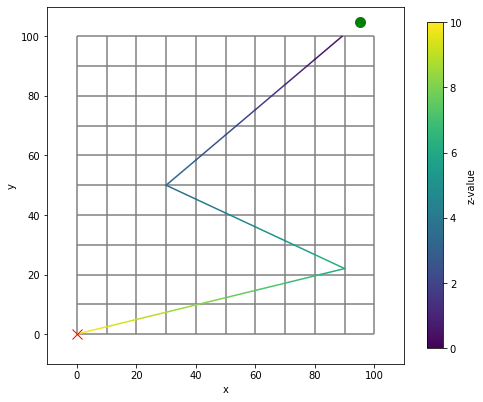

In [292]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

cmap = plt.get_cmap("viridis")
vmin = 0
vmax = 10
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# start and end pts
ax.plot(mls[0].xy[0][0:1], mls[0].xy[1][0:1], "go", zorder=5, ms=10)
ax.plot(mls[-1].xy[0][-1:], mls[-1].xy[1][-1:], "rx", zorder=5, ms=10)

c = cmap(norm(rec.z_interp))
plot_linestring(rec, ax=ax, c=c)

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), shrink=0.75)
cbar.set_label("z-value")

ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)
ax.set_xlabel("x")
ax.set_ylabel("y");